# Algorytm przecinania się odcinków na płaszczyźnie

In [1413]:
from enum import Enum
from functools import reduce

import numpy as np
import pandas as pd
import random

from sortedcontainers import SortedSet
from queue import PriorityQueue

from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Przydatne funkcje 

In [1414]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

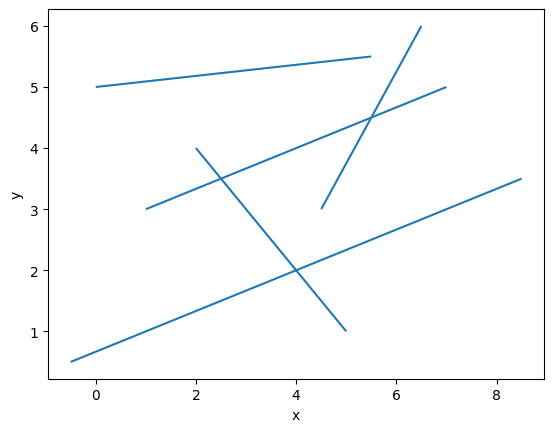

In [1415]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

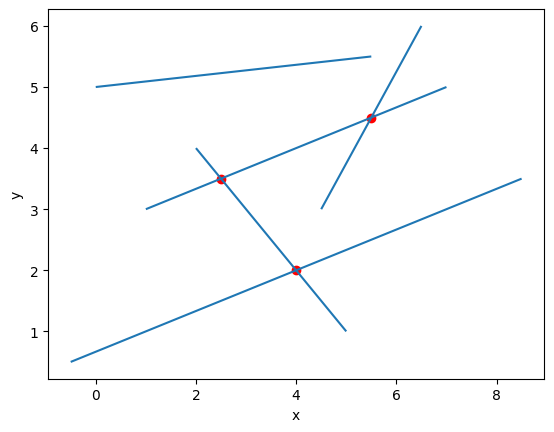

In [1416]:
draw_example_2()

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [1417]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    def gen_coordinate_list(limit):
        return [random.uniform(0, limit) for _ in range(n)]
    
    x1, x2 = gen_coordinate_list(max_x), gen_coordinate_list(max_x)
    y1, y2 = gen_coordinate_list(max_y), gen_coordinate_list(max_y)
    
    return [((x1[i], y1[i]), (x2[i], y2[i])) for i in range(n)]
    

In [1418]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.047s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [1419]:
section = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

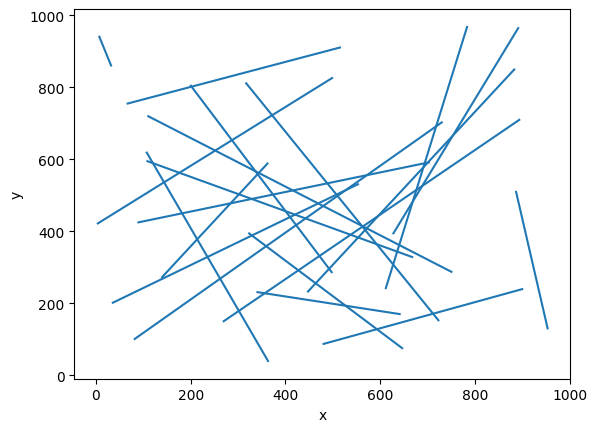

In [1420]:
vis = Visualizer()
for e in section:
    vis.add_line_segment(e)
vis.show()

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką (jak?) TODO

In [1421]:
%matplotlib tk
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt

lines = []
current_line = [] 

fig, ax = plt.subplots()
ax.set_title('Draw Lines')
plt.xlim(0, 10)
plt.ylim(0, 10)

def on_click(event):

    if event.button is MouseButton.LEFT and event.xdata is not None and event.ydata is not None:
        current_line.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, marker='.', color='blue')
        
        if len(current_line) == 2:
            line = (current_line[0], current_line[1])
            lines.append(line)
            ax.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], color='blue')
            current_line.clear()
            
        plt.show()

plt.connect('button_press_event', on_click)
plt.show(block=True)

%matplotlib inline

for line in lines:
    print("Start (x, y): ", line[0], " End (x, y): ", line[1])


Start (x, y):  (2.7419354838709675, 8.14935064935065)  End (x, y):  (8.14516129032258, 2.62987012987013)
Start (x, y):  (2.2983870967741935, 3.0357142857142856)  End (x, y):  (7.52016129032258, 8.176406926406928)
Start (x, y):  (2.9233870967741935, 6.066017316017317)  End (x, y):  (3.3669354838709675, 6.038961038961039)
Start (x, y):  (6.693548387096774, 5.633116883116884)  End (x, y):  (7.116935483870968, 5.497835497835498)


Uzupełnij funkcję ```is_intersection```

In [1422]:
def determinant(a, b, c):
    return (b[0] - a[0]) * (c[1] - a[1]) - (c[0] - a[0]) * (b[1] - a[1])

def orientation(a, b, c, eps=0):
    det = determinant(a, b, c)
    if det > eps:
        return 1
    elif det < eps:
        return -1
    
    return 0

In [1423]:
# Given three collinear points a, b, c, the function checks if
# point c lies on line segment 'ab'
def is_on_segment(a, b, c):
    return min(a[0], b[0]) <= c[0] <= max(a[0], b[0]) and min(a[1], b[1]) <= c[1] <= max(a[1], b[1])
    

In [1424]:
def check_intersection(A, B, eps=0):
    a_start = A[0]
    a_end = A[1]

    b_start = B[0]
    b_end = B[1]

    o1 = orientation(a_start, a_end, b_start)
    o2 = orientation(a_start, a_end, b_end)
    o3 = orientation(b_start, b_end, a_start)
    o4 = orientation(b_start, b_end, a_end)

    if o1 != o2 and o3 != o4:
        return True

    if -eps <= o1 <= eps and is_on_segment(a_start, a_end, b_start):
        return True

    if -eps <= o2 <= eps and is_on_segment(a_start, a_end, b_end):
        return True

    if -eps <= o3 <= eps and is_on_segment(b_start, b_end, a_start):
        return True

    if -eps <= o4 <= eps and is_on_segment(b_start, b_end, a_end):
        return True

    return False

In [1425]:
def is_intersection(sections, eps=0):
    
    def add_line(current_line):
        T.add(current_line)
        index = T.index(current_line)
        
        if index - 1 >= 0:
            return check_intersection(T[index - 1], current_line)
        
        if index + 1 < len(T):
            return check_intersection(T[index + 1], current_line)
        
        return False
    
    def remove_line(current_line):
        index = T.index(current_line)
        
        if index - 1 >= 0 and index + 1 < len(T):
            return check_intersection(T[index - 1], T[index + 1])
        
        T.remove(current_line)
        return False
    
    def state(current_event):
        if current_event[0] == current_event[1][0][0]:
            return add_line(current_event[1])
        
        else:
            return remove_line(current_event[1])
    

    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina 
    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps: epsilon będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """
        
    Q = PriorityQueue()
    T = SortedSet(key=lambda x: x[0][1])
    
    lines = dict()
    
    for line in sections:
        Q.put((line[0][0], line[0]))
        Q.put((line[1][0], line[1]))
        
        lines[line[0]] = line
        lines[line[1]] = line
            
    while not Q.empty():
        event = Q.get()
        
        x, point = event
        
        if state((x, lines[point])):
            return True
            
    return False

In [1426]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.000s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [1427]:
def is_intersection_with_visualization(sections):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    raise Exception("Unimplemented")

Uzupełnij funkcję ```find_intersections```

In [1428]:
class Edge_side(Enum):
    START = 0
    END = 1

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def lines(self, line_1, line_2):
        self.line_1 = line_1
        self.line_2 = line_2
        
    def get_lines(self):
        return self.line_1, self.line_2

    def __eq__(self, point):
        return self.x == point.x and self.y == point.y

    def __le__(self, point):
        return self.x <= point.x

    def __hash__(self):
        return self.x.__hash__() * self.y.__hash__()

    def to_tuple(self):
        return self.x, self.y
        
    
class Line:
    def __init__(self, start_point, end_point):
        self.point_1 = min(start_point, end_point, key=lambda p: p.x)
        self.point_2 = max(start_point, end_point, key=lambda p: p.x)

    def get_y(self, x):
        a = (self.point_2.y - self.point_1.y) / (self.point_2.x - self.point_1.x)
        b = self.point_2.y - a * self.point_2.x
        return a * x + b

    def to_tuple(self):
        return self.point_1.to_tuple(), self.point_2.to_tuple()
    

In [1429]:

def determinant2(a, b, c):
    return (b.x - a.x) * (c.y - a.y) - (c.x - a.x) * (b.y - a.y)

def is_on_segment2(a, b, c):
    return min(a.x, b.x) <= c.x <= max(a.x, b.x) and min(a.y, b.y) <= c.y <= max(a.y, b.y)


In [1430]:
def check_intersection2(A, B):
    a_start = A.point1
    a_end = A.point2
    
    b_start = B.point1
    b_end = B.point2
    
    o1 = orientation(a_start, a_end, b_start)
    o2 = orientation(a_start, a_end, b_end)
    o3 = orientation(b_start, b_end, a_start)
    o4 = orientation(b_start, b_end, a_end)
    
    if o1 != o2 and o3 != o4:
        return True
    
    if o1 == 0 and is_on_segment2(a_start, a_end, b_start):
        return True
    
    if o2 == 0 and is_on_segment2(a_start, a_end, b_end):
        return True
    
    if o3 == 0 and is_on_segment2(b_start, b_end, a_start):
        return True
    
    if o4 == 0 and is_on_segment2(b_start, b_end, a_end):
        return True
    
    return False

In [1431]:
def intersection_point(A, B):
    a1 = (A.point2.y - A.point1.y) / (A.point2.x - A.point1.x)
    b1 = A.point1.y - a1 * A.point1.x
    
    a2 = (B.point2.y - B.point1.y) / (B.point2.x - B.point1.x)
    b2 = B.point1.y - a2 * B.point1.x
    
    x = (b2 - b1) / (a1 - a2)
    y = a1 * x + b1
    
    return Point(x, y)

In [1432]:
def convert_to_point_lines(lines):
    for idx, line in enumerate(lines):
        point_1 = Point(line[0][0], line[0][1])
        point_2 = Point(line[1][0], line[1][1])
        lines[idx] = Line(point_1, point_2)
        
    return lines
    
class Broom:
    def __init__(self):
        # Struktura stanu
        self.T = SortedSet()
        
        # Struktura zdarzeń
        self.Q = SortedSet(key=lambda point: -point.x)
        
        self.lines = dict()
        self.intersection = set()
        self.lines_idx = dict()

    def sweep(self, lines):
        for idx, line in enumerate(lines):
            self.lines[line.point_1] = line
            self.lines[line.point_2] = line
            
            self.Q.add(line.point_1)
            self.Q.add(line.point_2)
            
            self.lines_idx[line.point_1] = idx
            self.lines_idx[line.point_2] = idx


        active_lines = SortedSet(key=lambda line: line.get_y(self.Q[0].x))
        active_lines.update(self.T)
        self.T = active_lines

        while len(self.Q) > 0:
            event = self.Q.pop()
            self.state(event)
            
        return self.intersection

    def state(self, event):
        
        if event in self.lines:
            line = self.lines[event]
            active_lines = SortedSet(key=lambda line: line.get_y(event.x))
            active_lines.update(self.T)
            self.T = active_lines
            
            if event == line.point_1:
                # jeśli p jest lewym końcem odcinka – dodaj odcinek do T
                self.add_line(line)
                
            else:
                # jeśli p jest prawym końcem odcinka – usuń odcinek z T
                self.remove_line(line)
                
        else:
            # jeśli p jest punktem przecięcia s i s’, zmień porządek s i s’ w T
            
            # TODO
            self.intersection.add(event)
            line_1 = event.line_1
            self.remove_line(line_1)
            line_2 = event.line_2
            self.remove_line(line_2)
            
            active_lines = SortedSet(key=lambda line: line.get_y(event.x + 10 ** (-12)))
            active_lines.update(self.T)
            self.T = active_lines

            self.add_line(line_1)
            self.add_line(line_2)

    def lines_intersection(self, line_1, line_2):
        orientation_11 = orientation(line_1.point_1.to_tuple(), line_1.point_2.to_tuple(), line_2.point_1.to_tuple())
        orientation_12 = orientation(line_1.point_1.to_tuple(), line_1.point_2.to_tuple(), line_2.point_2.to_tuple())
        orientation_21 = orientation(line_2.point_1.to_tuple(), line_2.point_2.to_tuple(), line_1.point_1.to_tuple())
        orientation_22 = orientation(line_2.point_1.to_tuple(), line_2.point_2.to_tuple(), line_1.point_2.to_tuple())

        if orientation_11 != orientation_12 and orientation_21 != orientation_22:
            a_1 = (line_1.point_2.y - line_1.point_1.y) / (line_1.point_2.x - line_1.point_1.x)
            b_1 = line_1.point_1.y - a_1 * line_1.point_1.x

            a_2 = (line_2.point_2.y - line_2.point_1.y) / (line_2.point_2.x - line_2.point_1.x)
            b_2 = line_2.point_1.y - a_2 * line_2.point_1.x

            x = (b_2 - b_1) / (a_1 - a_2)
            y = a_1 * (b_2 - b_1) / (a_1 - a_2) + b_1

            point = Point(x, y)
            point.lines(line_1, line_2)
            self.lines_idx[point] = (self.lines_idx[line_1.point_1], self.lines_idx[line_2.point_2])
            
            return point
        
        return None

    def add_line(self, line):
        self.T.add(line)
        
        index = self.T.index(line)

        if index - 1 >= 0:
            intersection = self.lines_intersection(self.T[index - 1], line)
            if intersection is not None and intersection not in self.Q and intersection not in self.intersection:
                self.Q.add(intersection)
                
        if index + 1 < len(self.T):
            intersection = self.lines_intersection(line, self.T[index + 1])
            if intersection is not None and intersection not in self.Q and intersection not in self.intersection:
                self.Q.add(intersection)

    def remove_line(self, line):
        index = self.T.index(line)

        if index - 1 >= 0 and index + 1 < len(self.T):
            intersection = self.lines_intersection(self.T[index - 1], self.T[index + 1])
            if intersection is not None and intersection not in self.intersection:
                self.Q.add(intersection)
                
        self.T.remove(line)

In [1433]:
def find_intersections(sections):
    
    lines = convert_to_point_lines(sections)
    
    broom = Broom()
    
    broom.sweep(lines)
    
    result = []
    
    intersection_points = set(broom.intersection)
    
    for point in intersection_points:
        result.append((point.to_tuple(), *broom.lines_idx[point]))
        
    return result

In [1434]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: WRONG ANSWER
		Output:   [((0.011526074740254208, 0.006132801296422439), 1, 2), ((0.022344451130778698, 0.01711175484919488), 1, 3), ((0.022344451130778698, 0.017111754849195027), 3, 1), ((0.022658670631229855, -0.02681736354721217), 0, 3), ((0.022658670631229855, -0.026817363547212647), 3, 0), ((0.011860591253227505, -0.01814014322949553), 2, 0), ((-0.0016743790516658117, -0.007263586832941072), 0, 1), ((0.011860591253227505, -0.018140143229495424), 0, 2), ((0.011526074740254208, 0.006132801296422352), 2, 1)]
		Expected: ['-0.0016743790516658117 -0.007263586832941072 1 2', '0.011526074740254208 0.006132801296422439 2 3', '0.011860591253227505 -0.018140143229495424 1 3', '0.022344451130778698 0.01711175484919488 2 4', '0.022658670631229855 -0.026817363547212168 1 4']
	Test 2: WRONG ANSWER
		Output:   [((0.010025601838031018, -0.020988202988542273), 1, 3), ((0.010025601838031018, -0.02098820298854228), 3, 1), ((0.013332591183346312, -0.01619339562692305), 2, 3), 

Uzupełnij funkcję ```find_intersections_with_visualization```

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

2
[((5.073442313168985, 5.767679590928368), 0, 1), ((5.073442313168985, 5.767679590928367), 1, 0)]


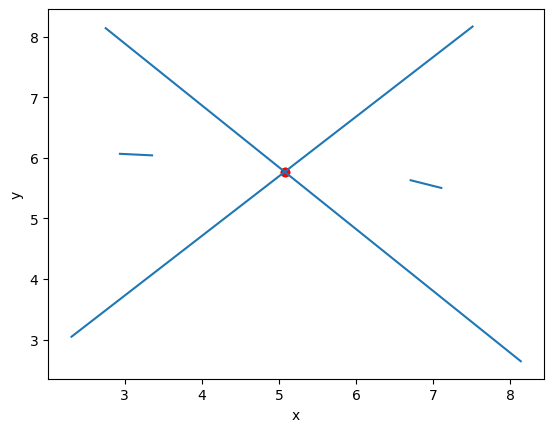

In [1435]:
if __name__ == '__main__':
    vis = Visualizer()
    
    for line in lines:
        vis.add_line_segment(line)
        
    res = find_intersections(lines)
    
    print(len(res))
    print(res)
    
    for inter_point in res:
        vis.add_point(inter_point[0], color='red')
        
    vis.show()